---
# **LAB - Transformers**
---

This notebook provides the simple walkthrough of the **Vision Transformer**, namely **ViT**.
- **Paper**: Alexey Dosovitskiy et al., "*An Image Is Worth 16x16 Words: Transformers for Image Recognition at Scale*", [arxiv.org/abs/2010.11929](https://arxiv.org/abs/2010.11929)

**Model Implementation**: this notebook uses the deep-learning library [timm](https://github.com/rwightman/pytorch-image-models/tree/master/timm) (documentation at [timmdocs](https://fastai.github.io/timmdocs/) site)

`timm` is a deep-learning library created by Ross Wightman and is a collection of SOTA computer vision models, layers, utilities, optimizers, schedulers, data-loaders, augmentations and also training/validating scripts with ability to reproduce ImageNet training results.



In [ ]:
!pip install timm
!pip install opencv-python

In [14]:
# print prtrained models
import os
import timm
import cv2
import PIL

from pprint import pprint

# ViT model
model_names = timm.list_models('*vit*base*patch*16*')
pprint(model_names)

['samvit_base_patch16',
 'samvit_base_patch16_224',
 'vit_base_patch16_18x2_224',
 'vit_base_patch16_224',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_384',
 'vit_base_patch16_clip_224',
 'vit_base_patch16_clip_384',
 'vit_base_patch16_clip_quickgelu_224',
 'vit_base_patch16_gap_224',
 'vit_base_patch16_plus_240',
 'vit_base_patch16_plus_clip_240',
 'vit_base_patch16_reg4_gap_256',
 'vit_base_patch16_rope_reg1_gap_256',
 'vit_base_patch16_rpn_224',
 'vit_base_patch16_siglip_224',
 'vit_base_patch16_siglip_256',
 'vit_base_patch16_siglip_384',
 'vit_base_patch16_siglip_512',
 'vit_base_patch16_siglip_gap_224',
 'vit_base_patch16_siglip_gap_256',
 'vit_base_patch16_siglip_gap_384',
 'vit_base_patch16_siglip_gap_512',
 'vit_base_patch16_xp_224',
 'vit_relpos_base_patch16_224',
 'vit_relpos_base_patch16_cls_224',
 'vit_relpos_base_patch16_clsgap_224',
 'vit_relpos_base_patch16_plus_240',
 'vit_relpos_base_patch16_rpn_224']


# Classes and functions

In [15]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import timm

class PatchEmbed(nn.Module):
  """Split image into patches and then embed them.
  Parameters
  ----------
  img_size   : (int) Size of the image (it is a square).
  patch_size : (int) Size of the patch (it is a square).
  in_chans   : (int) Number of input channels.
  embed_dim  : (int) The emmbedding dimension.
  
  Attributes
  ----------
  n_patches : (int) Number of patches inside of our image.
  proj : nn.Conv2d: Convolutional layer that does both the splitting into patches and their embedding.
  """
  def __init__(self, img_size, patch_size, in_chans=3, embed_dim=768):
    super().__init__()
    self.img_size = img_size
    self.patch_size = patch_size
    self.n_patches = (img_size // patch_size) ** 2
    self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

  def forward(self, x):
    """Run forward pass.
    Parameters
    ----------
    x : torch.Tensor
        Shape `(n_samples, in_chans, img_size, img_size)`.
    Returns
    -------
    torch.Tensor
        Shape `(n_samples, n_patches, embed_dim)`.
    """
    x = self.proj(x)       # (n_samples, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
    x = x.flatten(2)        # (n_samples, embed_dim, n_patches)
    x = x.transpose(1, 2)  # (n_samples, n_patches, embed_dim)

    return x

class Attention(nn.Module):
  """Attention mechanism.

  Parameters
  ----------
    dim      : (int)   The input and out dimension of per token features.
    n_heads  : (int)   Number of attention heads.
    qkv_bias : (bool)  If True then we include bias to the query, key and value projections.
    attn_p   : (float) Dropout probability applied to the query, key and value tensors.
    proj_p   : (float) Dropout probability applied to the output tensor.
    
  Attributes
  ----------
    scale : float
        Normalizing consant for the dot product.
    qkv : nn.Linear
        Linear projection for the query, key and value.
    proj : nn.Linear
        Linear mapping that takes in the concatenated output of all attention
        heads and maps it into a new space.
    attn_drop, proj_drop : nn.Dropout
        Dropout layers.
  """

  def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
    super().__init__()
    self.n_heads = n_heads
    self.dim = dim
    self.head_dim = dim // n_heads
    self.scale = self.head_dim ** -0.5

    self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
    self.attn_drop = nn.Dropout(attn_p)
    self.proj = nn.Linear(dim, dim)
    self.proj_drop = nn.Dropout(proj_p)

  def forward(self, x):
    """Run forward pass.
    Parameters
    ----------
    x : torch.Tensor
        Shape `(n_samples, n_patches + 1, dim)`.
    Returns
    -------
    torch.Tensor
        Shape `(n_samples, n_patches + 1, dim)`.
    """
    n_samples, n_tokens, dim = x.shape

    if dim != self.dim:
      raise ValueError

    qkv = self.qkv(x)  # (n_samples, n_patches + 1, 3 * dim)
    qkv = qkv.reshape(n_samples, n_tokens, 3, self.n_heads, self.head_dim)  # (n_saples, n_patches + 1, 3, n_heads, head_dim)
    qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, n_samples, n_heads, n_patches + 1, head_dim)

    # compute att matrices
    q, k, v = qkv[0], qkv[1], qkv[2]
    k_t = k.transpose(-2, -1)   # (n_samples, n_heads, head_dim, n_patches + 1)
    dp = (q @ k_t) * self.scale # (n_samples, n_heads, n_patches + 1, n_patches + 1)
    attn = dp.softmax(dim=-1)   # (n_samples, n_heads, n_patches + 1, n_patches + 1)
    attn = self.attn_drop(attn)

    # compute weigthed avg
    weighted_avg = attn @ v  # (n_samples, n_heads, n_patches +1, head_dim)
    weighted_avg = weighted_avg.transpose(1, 2)  # (n_samples, n_patches + 1, n_heads, head_dim)
    weighted_avg = weighted_avg.flatten(2)  # (n_samples, n_patches + 1, dim)

    # linear projection
    x = self.proj(weighted_avg)  # (n_samples, n_patches + 1, dim)
    x = self.proj_drop(x)        # (n_samples, n_patches + 1, dim)

    return x

class MLP(nn.Module):
    """Multilayer perceptron.
    Parameters
    ----------
    in_features : int
        Number of input features.
    hidden_features : int
        Number of nodes in the hidden layer.
    out_features : int
        Number of output features.
    p : float
        Dropout probability.
    Attributes
    ----------
    fc : nn.Linear
        The First linear layer.
    act : nn.GELU
        GELU activation function.
    fc2 : nn.Linear
        The second linear layer.
    drop : nn.Dropout
        Dropout layer.
    """
    def __init__(self, in_features, hidden_features, out_features, p=0.):
      super().__init__()
      self.fc1 = nn.Linear(in_features, hidden_features)
      self.act = nn.GELU()
      self.fc2 = nn.Linear(hidden_features, out_features)
      self.drop = nn.Dropout(p)

    def forward(self, x):
      """Run forward pass.
      Parameters
      ----------
      x : torch.Tensor
          Shape `(n_samples, n_patches + 1, in_features)`.
      Returns
      -------
      torch.Tensor
          Shape `(n_samples, n_patches +1, out_features)`
      """
      x = self.fc1(x)   # (n_samples, n_patches + 1, hidden_features)
      x = self.act(x)   # (n_samples, n_patches + 1, hidden_features)
      x = self.drop(x)  # (n_samples, n_patches + 1, hidden_features)
      x = self.fc2(x)   # (n_samples, n_patches + 1, hidden_features)
      x = self.drop(x)  # (n_samples, n_patches + 1, hidden_features)

      return x

class Block(nn.Module):
    """Transformer block.
    Parameters
    ----------
    dim : int
        Embeddinig dimension.
    n_heads : int
        Number of attention heads.
    mlp_ratio : float
        Determines the hidden dimension size of the `MLP` module with respect
        to `dim`.
    qkv_bias : bool
        If True then we include bias to the query, key and value projections.
    p, attn_p : float
        Dropout probability.
    Attributes
    ----------
    norm1, norm2 : LayerNorm
        Layer normalization.
    attn : Attention
        Attention module.
    mlp : MLP
        MLP module.
    """
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
      super().__init__()
      self.norm1 = nn.LayerNorm(dim, eps=1e-6)
      self.attn = Attention(dim, n_heads=n_heads, qkv_bias=qkv_bias, attn_p=attn_p, proj_p=p)
      self.norm2 = nn.LayerNorm(dim, eps=1e-6)
      hidden_features = int(dim * mlp_ratio)
      self.mlp = MLP(in_features=dim, hidden_features=hidden_features, out_features=dim)

    def forward(self, x):
      """Run forward pass.
      
      Parameters
      ----------
        x : torch.Tensor
          Shape `(n_samples, n_patches + 1, dim)`.
      
      Returns
      -------
        torch.Tensor
          Shape `(n_samples, n_patches + 1, dim)`.
      """
      
      x = x + self.attn(self.norm1(x))
      x = x + self.mlp(self.norm2(x))

      return x

class VisionTransformer(nn.Module):
  """Simplified implementation of the Vision transformer.

  Parameters
  ----------
  img_size : int
      Both height and the width of the image (it is a square).
  patch_size : int
      Both height and the width of the patch (it is a square).
  in_chans : int
      Number of input channels.
  n_classes : int
      Number of classes.
  embed_dim : int
      Dimensionality of the token/patch embeddings.
  depth : int
      Number of blocks.
  n_heads : int
      Number of attention heads.
  mlp_ratio : float
      Determines the hidden dimension of the `MLP` module.
  qkv_bias : bool
      If True then we include bias to the query, key and value projections.
  p, attn_p : float
      Dropout probability.

  Attributes
  ----------
  patch_embed : PatchEmbed
      Instance of `PatchEmbed` layer.
  cls_token : nn.Parameter
      Learnable parameter that will represent the first token in the sequence.
      It has `embed_dim` elements.
  pos_emb : nn.Parameter
      Positional embedding of the cls token + all the patches.
      It has `(n_patches + 1) * embed_dim` elements.
  pos_drop : nn.Dropout
      Dropout layer.
  blocks : nn.ModuleList
      List of `Block` modules.
  norm : nn.LayerNorm
      Layer normalization.
  """
  def __init__(
          self,
          img_size=224,
          patch_size=16,
          in_chans=3,
          n_classes=1000,
          embed_dim=768,
          depth=12,
          n_heads=12,
          mlp_ratio=4.,
          qkv_bias=True,
          p=0.,
          attn_p=0.,
  ):
    super().__init__()

    self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
    )
    self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
    self.pos_embed = nn.Parameter(
            torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim)
    )
    self.pos_drop = nn.Dropout(p=p)

    self.blocks = nn.ModuleList(
        [
            Block(
                dim=embed_dim,
                n_heads=n_heads,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                p=p,
                attn_p=attn_p,
            )
            for _ in range(depth)
        ]
    )

    self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
    self.head = nn.Linear(embed_dim, n_classes)

  def forward(self, x):
    """Run the forward pass.
    Parameters
    ----------
    x : torch.Tensor
        Shape `(n_samples, in_chans, img_size, img_size)`.
    Returns
    -------
    logits : torch.Tensor
        Logits over all the classes - `(n_samples, n_classes)`.
    """
    n_samples = x.shape[0]
    x = self.patch_embed(x)

    cls_token = self.cls_token.expand(n_samples, -1, -1)  # (n_samples, 1, embed_dim)
    x = torch.cat((cls_token, x), dim=1)  # (n_samples, 1 + n_patches, embed_dim)
    x = x + self.pos_embed  # (n_samples, 1 + n_patches, embed_dim)
    x = self.pos_drop(x)

    for block in self.blocks:
      x = block(x)

    x = self.norm(x)

    cls_token_final = x[:, 0]  # just the CLS token
    x = self.head(cls_token_final)

    return x

# Helpers
def get_n_params(module):
    return sum(p.numel() for p in module.parameters() if p.requires_grad)

def assert_tensors_equal(t1, t2):
    a1, a2 = t1.detach().numpy(), t2.detach().numpy()

    np.testing.assert_allclose(a1, a2)

def copy_from_pretrained(model, model_pretrained="vit_base_patch16_224", verb=False):

  # pretrained model from timm package
  model_official = timm.create_model(model_pretrained, pretrained=True)
  if verb:
    model_official.eval()
    print(type(model_official))

  for (n_o, p_o), (n_c, p_c) in zip(model_official.named_parameters(), model.named_parameters()):
    assert p_o.numel() == p_c.numel()
    p_c.data[:] = p_o.data
    assert_tensors_equal(p_c.data, p_o.data)

  # Asserts
  assert get_n_params(model) == get_n_params(model_official)
  

# Create model and initial setup

Choose device (to enable GPU on Colab use the Runtime menu)...

In [16]:
# choose device: 'cpu' or 'gpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)

device =  cuda


In [23]:
img_dir = './img/'

In [24]:
# load class labels
class_labels_file = './ImageNet_classes.txt'
imagenet_labels = dict(enumerate(open(class_labels_file)))
print(imagenet_labels[0])

tench, Tinca_tinca



Make a new model using the class `VisionTransformer` and instead of learning from the dataset (it takes long time!) use a pretrained model by copying its parameters...

In [19]:
# Model configuration
custom_config = {
        "img_size": 224,
        "in_chans": 3,
        "patch_size": 16,
        "embed_dim": 768,
        "depth": 12,
        "n_heads": 12,
        "qkv_bias": True,
        "mlp_ratio": 4
}

# model setup
model = VisionTransformer(**custom_config)
print(model)

# create a pretrained model
model_pretrained_name ="vit_base_patch16_224"
model = timm.create_model(model_pretrained_name, pretrained=True).to(device)
 

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (head): Linear(in_features=768, out_features=1000, bi

# Vision Transformer Pipeline

<img src='https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/vit_input.png?raw=true' width='100%'>


1. **Split Image into Patches**  
The input image is split into 14 x 14 vectors with dimension of 768 by Conv2d (k=16x16) with stride=(16, 16). 
2. **Add Position Embeddings**  
Learnable position embedding vectors are added to the patch embedding vectors and fed to the transformer encoder. 
3. **Transformer Encoder**  
The embedding vectors are encoded by the transformer encoder. The dimension of input and output vectors are the same. Details of the encoder are depicted in Fig. 2.
4. **MLP (Classification) Head**  
The 0th output from the encoder is fed to the MLP head for classification to output the final classification results.

## 1. Split Image into Patches + Embedding



The input image is split into $N=196$ patches ($N = 14\times 14$ for ViT-Base)
and converted to $D=768$ embedding vectors by learnable 2D convolution:
```
Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
```

[ WARN:0@232.150] global loadsave.cpp:268 findDecoder imread_('../../img/Santorini_Dome.jpg'): can't open/read file: check file path/integrity


TypeError: Image data of dtype object cannot be converted to float

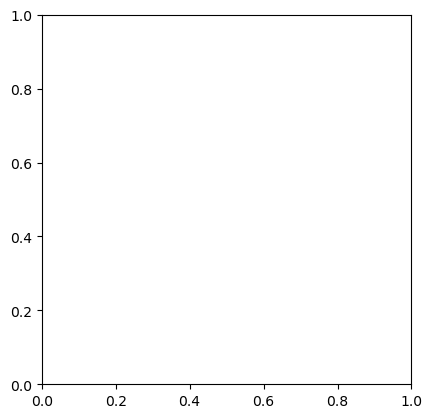

In [22]:
# choose an image to classify
img_filename = img_dir + 'Santorini_Dome.jpg'
img = cv2.imread(img_filename)
plt.imshow(img)

img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
print('Img size:', img.shape)
img = Image.fromarray(np.uint8(img))

fig = plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()
 

Setup the image transformations: [TORCHVISION.TRANSFORMS](https://pytorch.org/vision/stable/transforms.html) is a collection of classes for common image transformations. 

In [ ]:
# image transforms: resize & normalization  
import torchvision.transforms as T

IMG_SIZE = (224, 224)
NORMALIZE_MEAN = (0.5, 0.5, 0.5)
NORMALIZE_STD = (0.5, 0.5, 0.5)
transforms = [T.Resize(IMG_SIZE), T.ToTensor(),
              T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD)]
transforms = T.Compose(transforms)
print(transforms)

# transformed image
img_tensor = transforms(img).unsqueeze(0).to(device) # add a dimension for batch
print('\nTransformed image dims:', img_tensor.shape)

In [ ]:
# patch embedding convolution
patches = model.patch_embed(img_tensor)  
print("Image tensor: ", img_tensor.shape)
print("Patch embeddings: ", patches.shape)

In [ ]:
# The image is resized and divided into 196=14x14 patches (16 x 16)
# This code is NOT in the pipeline

I = np.asarray(img.resize((224,224)))
print('Img size:', I.size)
fig = plt.figure(figsize=(10, 10))
plt.imshow(I)
plt.title("Resized image", fontsize=20)
plt.show()

fig = plt.figure(figsize=(10, 10))
fig.suptitle("Visualization of Patches", fontsize=20)

for i in range(0, 196):
    x = i % 14
    y = i // 14
    patch = I[y*16:(y+1)*16, x*16:(x+1)*16]
    ax = fig.add_subplot(14, 14, i+1)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(patch)

## 2. Add Position Embeddings


To make patches position-aware, learnable **position embedding** vectors are added to the **patch embedding** vectors. The position embedding vectors learn distance within the image thus neighboring ones have high similarity.

`torch.nn.functional.cosine_similarity(x1, x2, dim=1, eps=1e-08) → Tensor`

Returns cosine similarity between $x_1$ and $x_2$, computed along `dim`.  Dimension dim of the output is squeezed (see `torch.squeeze()`), resulting in the output tensor having 1 fewer dimension.

In [8]:
# Dimension of position embeddings
pos_embed = model.pos_embed
print('Patch embed + [cls] token : ', pos_embed.shape)

print('\nGiven by...\n')

# Patch embed by Conv2D
patch_embed = model.patch_embed
print('  -  CONV net :', patch_embed)

# [cls] token shape
print('\n  -  [cls] token shape : ', model.cls_token.shape)

Patch embed + [cls] token :  torch.Size([1, 197, 768])

Given by...

  -  CONV net : PatchEmbed(
  (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (norm): Identity()
)

  -  [cls] token shape :  torch.Size([1, 1, 768])


In [9]:
pos_embed.shape

torch.Size([1, 197, 768])

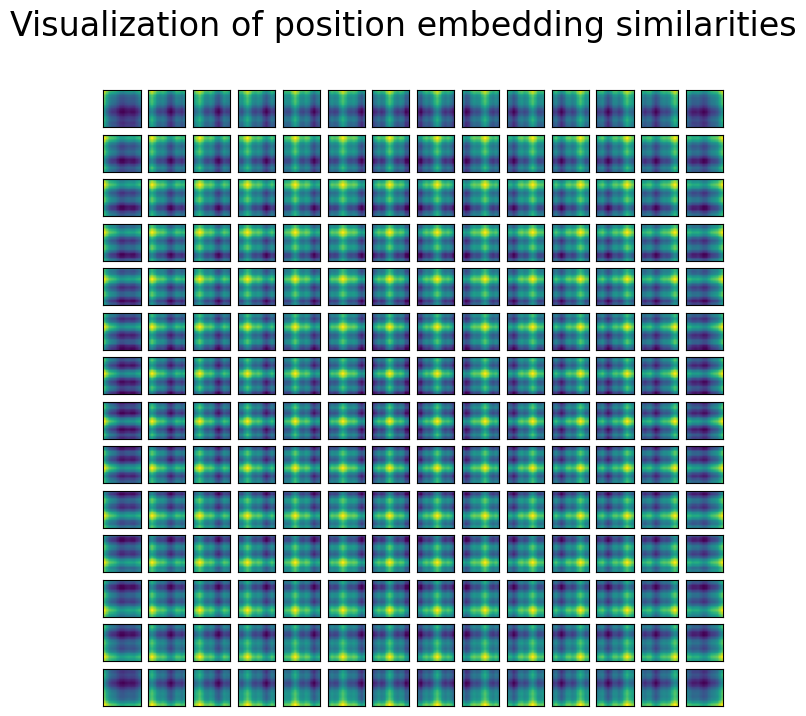

In [10]:
# Visualize position embedding similarities.
# One cell shows cos similarity between an embedding and all the other embeddings.
import torch.nn.functional as F

fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualization of position embedding similarities", fontsize=24)
for i in range(1, pos_embed.shape[1]):
    #sim = F.cosine_similarity(pos_embed[0, i], pos_embed[0, 1:], dim=1)
    sim = F.cosine_similarity(pos_embed[0, i].unsqueeze(0), pos_embed[0, 1:], dim=1)
    sim = sim.reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(14, 14, i)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(sim)

**Make Transformer Input**

A learnable class token is prepended to the patch embedding vectors as the 0th vector.
197 (1 + 14 x 14) learnable position embedding vectors are added to the patch embedding vectors.

In [11]:
print("cls_token size   : ", model.cls_token.shape)
print("patches size     : ", patches.shape)
print("pos_embed size   : ", pos_embed.shape)

transformer_input = torch.cat((model.cls_token, patches), dim=1) + pos_embed
print("Transformer input: ", transformer_input.shape)

cls_token size   :  torch.Size([1, 1, 768])


NameError: name 'patches' is not defined

## 3. Transformer Encoder



<img src='https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/transformer_encoder.png?raw=true'>

Figure 2. Detailed schematic of Transformer Encoder. 
- N (=197) embedded vectors are fed to the L (=12) series encoders. 
- The vectors are divided into query, key and value after expanded by an fc layer. 
- q, k and v are further divided into H (=12) and fed to the parallel attention heads. 
- Outputs from attention heads are concatenated to form the vectors whose shape is the same as the encoder input.
- The vectors go through an fc, a layer norm and an MLP block that has two fc layers.

The Vision Transformer employs the Transformer Encoder that was proposed in the [Attention is all you need paper](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf). 


In [12]:
# Series Transformer Encoders (num of blocks)

print("Input tensor to Transformer (z0): ", transformer_input.shape)
x = transformer_input.clone()
for i, blk in enumerate(model.blocks):
    print("Entering the Transformer Encoder {}".format(i))
    x = blk(x)
x = model.norm(x)
transformer_output = x[:, 0]
print("Output vector from Transformer (z12-0):", transformer_output.shape)

NameError: name 'transformer_input' is not defined

**How Attention Works**: In this part, we are going to see what the actual attention looks like.

In [19]:
print("Transformer Multi-head Attention block:")
attention = model.blocks[0].attn
print(attention)
print("\ninput of the transformer encoder:", transformer_input.shape)

Transformer Multi-head Attention block:
Attention(
  (qkv): Linear(in_features=768, out_features=2304, bias=True)
  (q_norm): Identity()
  (k_norm): Identity()
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=768, out_features=768, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)

input of the transformer encoder: torch.Size([1, 197, 768])


In [20]:
# fc layer to expand the dimension
transformer_input_expanded = attention.qkv(transformer_input)[0]
print("expanded to: ", transformer_input_expanded.shape)

expanded to:  torch.Size([197, 2304])


In [21]:
# Split qkv into mulitple q, k, and v vectors for multi-head attantion
qkv = transformer_input_expanded.reshape(197, 3, 12, 64)  # (N=197, (qkv), H=12, D/H=64)
print("split qkv : ", qkv.shape)
q = qkv[:, 0].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
k = qkv[:, 1].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
kT = k.permute(0, 2, 1)  # (H=12, D/H=64, N=197)
print("transposed ks: ", kT.shape)

split qkv :  torch.Size([197, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 197])


attention matrix:  torch.Size([12, 197, 197])


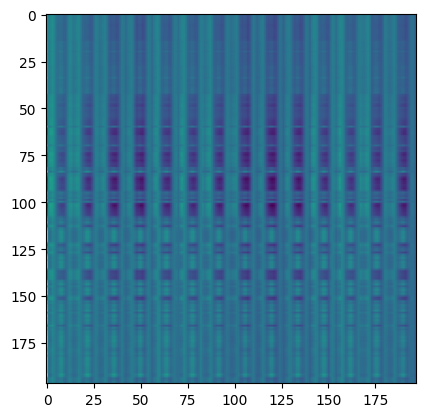

In [22]:
# Attention Matrix
attention_matrix = q @ kT
print("attention matrix: ", attention_matrix.shape)
plt.imshow(attention_matrix[3].detach().cpu().numpy())
plt.show()

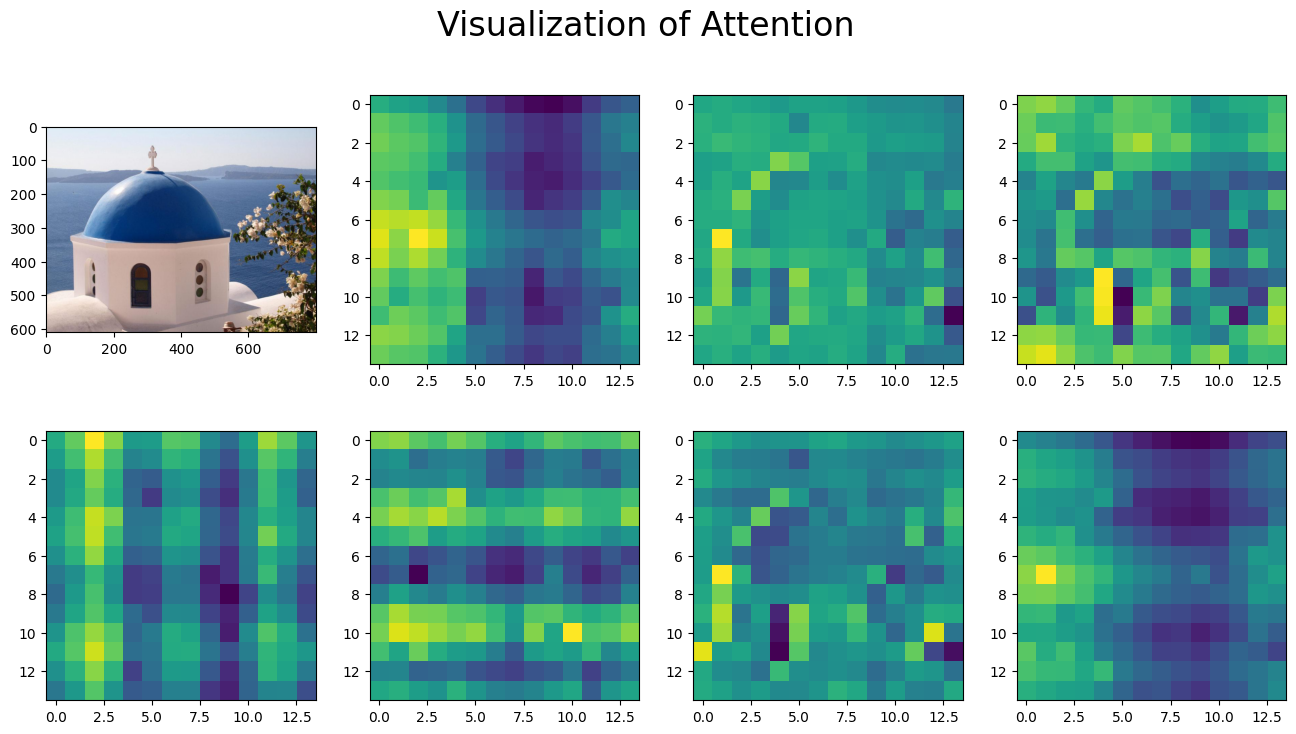

In [24]:
# Visualize attention matrix
fig = plt.figure(figsize=(16, 8))
fig.suptitle("Visualization of Attention", fontsize=24)
img = np.asarray(img)
ax = fig.add_subplot(2, 4, 1)
ax.imshow(img)
for i in range(7):  # visualize the 100th rows of attention matrices in the 0-7th heads
    attn_heatmap = attention_matrix[i, 100, 1:].reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(2, 4, i+2)
    ax.imshow(attn_heatmap)

## 4. MLP (Classification) Head
The 0-th output vector from the transformer output vectors (corresponding to the class token input) is fed to the MLP head.  

The 1000-dimension classification result is the output of the whole pipeline.

In [28]:
# class labels 
class_labels = img_filename = './ImageNet_classes.txt'
imagenet_labels = dict(enumerate(open(class_labels)))

# end-to-end inference
print("Classification head: ", model.head)
result = model.head(transformer_output)
class_idx = int(torch.argmax(result))

label = imagenet_labels[class_idx].rstrip('\n')
print(f"Inference Result: class label = {label}, class ID = {class_idx}")

Classification head:  Linear(in_features=768, out_features=1000, bias=True)
Inference Result: class label = dome, class ID = 538


# End-to-end inference

Img size: (720, 340)


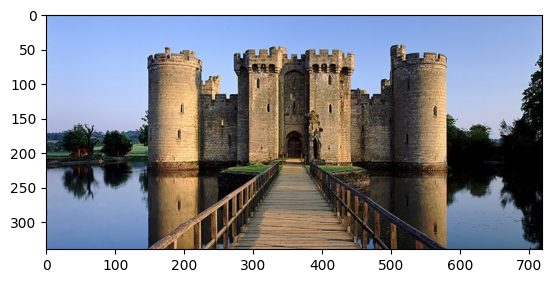


--------------------------------------------------

Number of ImageNet classes = 1000

--------------------------------------------------

Inference Result: class label = castle, class ID = 483

--------------------------------------------------

top k = 10 classes:
0: castle                                        --- 0.9017
1: palace                                        --- 0.0065
2: suspension_bridge                             --- 0.0008
3: lawn_mower, mower                             --- 0.0003
4: black_swan, Cygnus_atratus                    --- 0.0003
5: lakeside, lakeshore                           --- 0.0003
6: refrigerator, icebox                          --- 0.0003
7: dam, dike, dyke                               --- 0.0003
8: groom, bridegroom                             --- 0.0003
9: church, church_building                       --- 0.0003

--------------------------------------------------

Histogram of all (1000) classes


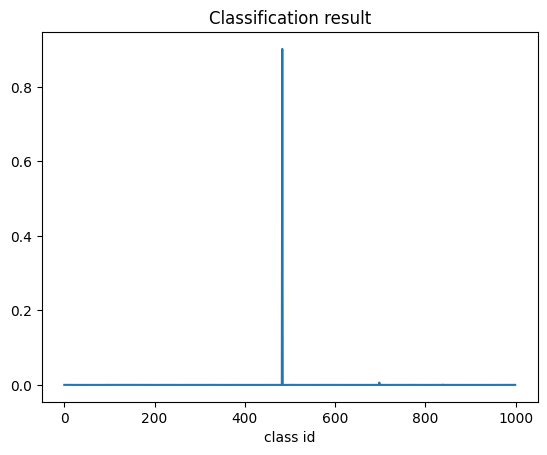

In [31]:
import timm 
import torchvision.transforms as T

# load image

#img_filename = img_dir + 'ponte.jpeg' 
img_filename = img_dir + 'castello_medievale.jpg'
img = Image.open(img_filename)
print('Img size:', img.size)
plt.imshow(img)
plt.show()
print('\n--------------------------------------------------\n')

# load a Transformer (pretrained) model
device = 'cpu'
model_pretrained_name ="vit_base_patch16_224"
model = timm.create_model(model_pretrained_name, pretrained=True).to(device)

# Define transforms for test
IMG_SIZE = (224, 224)
NORMALIZE_MEAN = (0.5, 0.5, 0.5)
NORMALIZE_STD = (0.5, 0.5, 0.5)
transforms = [T.Resize(IMG_SIZE), T.ToTensor(),
              T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD)]
transforms = T.Compose(transforms)

# load ImageNet class names
class_labels = './ImageNet_classes.txt'
imagenet_labels = dict(enumerate(open(class_labels)))
print(f"Number of ImageNet classes = {len(imagenet_labels)}")
print('\n--------------------------------------------------\n')

# apply transforms
img_tensor = transforms(img).unsqueeze(0).to(device)

# end-to-end inference
output = model(img_tensor)
class_idx = int(torch.argmax(output))
label = imagenet_labels[class_idx].rstrip('\n')
print(f"Inference Result: class label = {label}, class ID = {class_idx}")
print('\n--------------------------------------------------\n')

# print top-k classes
k = 10
probs = torch.nn.functional.softmax(output, dim=-1)
top_probs, top_ixs = probs[0].topk(k)
print(f"top k = {k} classes:")
for i, (ix_, prob_) in enumerate(zip(top_ixs, top_probs)):
    ix = ix_.item()
    prob = prob_.item()
    cls = imagenet_labels[ix].strip()
    print(f"{i}: {cls:<45} --- {prob:.4f}")
print('\n--------------------------------------------------\n')

# histogram of all (1000) classes
print("Histogram of all (1000) classes")
plt.plot(probs.detach().numpy()[0])
plt.title("Classification result")
plt.xlabel("class id")
plt.show()